# Static Margin

This section computes the static margin (most important parameter for longitudinal stability) for the example airplane. It refers to the distance between the neutral point (NP) and the most aft CG location, normalized by the mean aerodynamic chord (MAC). The NP denotes a location about which aircraft pitching moment does not change with respect to angle of attack ($\alpha$) i.e. the aircraft will be neutrally stable in longitudinal axis. This implies that any movement of CG beyond this point leads to aircraft being unstable. Refer to lecture notes and Section 16.3.1 and 16.3.2 in Raymer for a detailed explanation.

Using equation 16.9 in Raymer, the NP can be estimated using

$$
    \bar{X}_{np} = \frac{ C_{L_{\alpha_w}} \bar{X}_{ac_w} - C_{M_{\alpha_f}} + \eta_h \dfrac{S_h}{S_w} C_{L_{\alpha_h}} \dfrac{\partial \alpha_h}{\partial \alpha} \bar{X}_{ac_h} } { C_{L_{\alpha_w}} + \eta_h \dfrac{S_h}{S_w} C_{L_{\alpha_h}} \dfrac{\partial \alpha_h}{\partial \alpha} }.
$$

The $C_{L_{\alpha_w}}$ and $C_{L_{\alpha_h}}$ represents lift curve slope for the wing and the horizontal tail, respectively. The $C_{M_{\alpha_f}}$ denotes pitching moment derivative for the fuselage. The factor $n_h$ accounts for the decrease in the free-stream dynamic pressure experienced by the tail. The $S_h$ and $S_w$ refer to the reference area of wing and horizontal tail, respectively. The distance $X$ is measured from the leading edge of the MAC and $\bar{X}$ represents distance normalized using MAC, while the subscript ac refers to the aerodynamic center.

> __*NOTE*__: The effect of thrust/propulsion system are ignored in above equation, and hence, it yields power-off neutral point. To account for the thrust effects in NP, Raymer recommends 2% reduction per unit distance between the propeller and CG, normalized by MAC.

The following sub-sections define/compute the required parameters for estimating the neutral point. 

## Wing

The lift curve slope $C_{L_{\alpha_w}}$ for the wing is already computed in the [aerodynamics section](../aerodynamics/lift_curve.ipynb). For subsonic flows, the mean aerodynamic center is usually at 25% of the MAC. The wing reference area is estimated from the [initial sizing process](../wing_layout.ipynb). Below code block defines these parameters:

In [2]:
# Wing variables
Sw = 134 # sq ft
CLalpha_w = 5.0 # 1/rad
mac = 4.3 # ft
Xac_w = 0.25 # at quarter chord of the wing MAC

## Tail

The $C_{L_{\alpha_h}}$ is computed using the method described in [aerodynamics section](../aerodynamics/lift_curve.ipynb).It is assumed that the $F = 1$ and $S_{exposed}/S_{ref} \approx 1$. The factor $n_h$ is set to 0.9 as recommended by Raymer. The change in angle of attack at horizontal tail with respect to the free-stream angle of attack is computed using:

$$
    \frac{\partial \alpha_h}{\partial \alpha} = 1 - \frac{\partial \epsilon}{\partial \alpha},
$$

where $\epsilon$ accounts for the downwash effect. The $\partial \epsilon/ \partial \alpha$ can be computed using

$$
    \frac{\partial \epsilon}{\partial \alpha} = \bigg(\frac{\partial \epsilon}{\partial \alpha}\bigg)_{M=0} \frac{C_{L_{\alpha_h}}}{C_{L_{\alpha_h}}|_{M=0}},
$$

where $\partial \epsilon/ \partial \alpha$ at $M=0$ depends on the location of the horizonal tail with respect to wing, and can be estimated using Figure 16.12 in Raymer.

Below code block computes these horizontal tail parameters:

In [3]:
import numpy as np

# Tail parameters
nh = 0.9
Sh = 31 # sq ft
tail_moment_arm = 15 # ft
Xac_h = Xac_w + tail_moment_arm/mac # distance from LE MAC

# HT lift curve slope calculation
A_ht = 5.45
M = 0.3
sweep_ht = 10*np.pi/180 # deg, quarter chord
beta = (1 - M**2)**0.5
eta = 1.0

numerator = 2*np.pi*A_ht
denominator = 2 + (4 + (A_ht*beta/eta)**2 * (1 + (np.tan(sweep_ht)/beta)**2) )**0.5

CLalpha_ht = numerator / denominator # 1/rad

print(f"Lift curve slope for HT: {CLalpha_ht:.4f} 1/rad")

# HT lift curve slope at M = 0
M = 0.0
beta = (1 - M**2)**0.5
denominator = 2 + (4 + (A_ht*beta/eta)**2 * (1 + (np.tan(sweep_ht)/beta)**2) )**0.5
CLalpha_ht_M0 = numerator / denominator # 1/rad

# change in HT alpha wrt freestream alpha
de_da_M0 = 0.37 # from figure 16.12
de_da = de_da_M0 * CLalpha_ht / CLalpha_ht_M0
dah_da = 1 - de_da

print(f"Change in HT AOA wrt free-stream AOA: {dah_da:.4f}")

Lift curve slope for HT: 4.4747 1/rad
Change in HT AOA wrt free-stream AOA: 0.6188


## Fuselage

The fuselage pitching moment $C_{M_{\alpha_f}}$ is computed using the method described in Section 16.3.8 in Raymer. 

Below code block computes the fuselage pitching moment:

In [4]:
Kfus = 0.015 # from figure 16.14
Wf = 5.0 # ft
Lf = 31.6 # ft
mac = 4.3 # ft
Sw = 134 # sq ft

Cm_alpha_fuselage = Kfus * Wf**2 * Lf / mac / Sw * 180 / np.pi # 1/rad

print(f"Fuselage pitching moment: {Cm_alpha_fuselage:.4f} 1/rad") # 1/rad

Fuselage pitching moment: 1.1783 1/rad


## Neutral point

All the terms required for estimating the NP are computed. A correction factor is used to account for the propulsion system based on the distance of the propeller from the most aft CG location (computed in [CG travel diagram section](../weight_and_balance/cg_travel.ipynb)). Moreover, as described in Raymer Section 16.5, the control surface deflections are changed as $\alpha$ or side-slip angle vary during flight. Hence, one should perform stick-free stability analysis for smaller airplanes. To account for the stick-free analysis, the computed NP is moved towards CG by 3.5%. 

Below code block computes the NP for the example airplane:

In [5]:
numerator = CLalpha_w * Xac_w - Cm_alpha_fuselage + nh * Sh / Sw * CLalpha_ht * dah_da * Xac_h
denominator = CLalpha_w + nh * Sh / Sw * CLalpha_ht * dah_da

dist_prop_mac = 4.65 # ft

Xnp = (1 - 0.035) * (1 - 0.02*dist_prop_mac/mac) * numerator/denominator

print(f"Neutral point location: {Xnp:.3f} fraction of the MAC")

Neutral point location: 0.377 fraction of the MAC


## Static Margin

The location of the most aft CG is 0.1861 fraction of the MAC (computed in [CG travel diagram section](../weight_and_balance/cg_travel.ipynb)). This results in a **static margin of 19%**. Following code block plots CG travel diagram with neutral point and static margin:

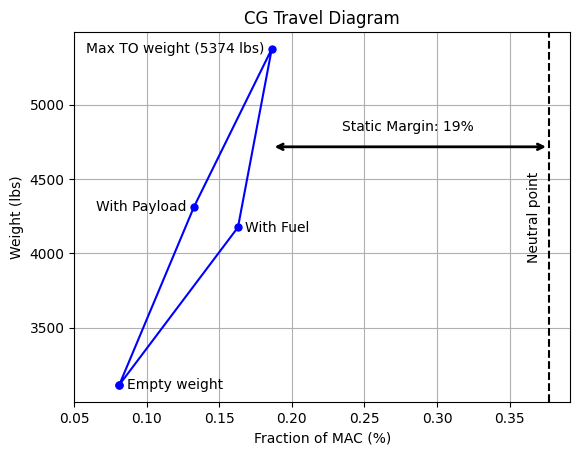

In [18]:
import matplotlib.pyplot as plt

# CG location as fraction of MAC
Xcg_empty = 0.081
Xcg_fuel_only = 0.1628
Xcg_pay_only = 0.1326
Xcg_full = 0.1861

# Weights, lbs
Wempty = 3114
Wfuel_only = 3114 + 1060
Wpay_only = 3114 + 1200
Wfull = 3114 + 1060 + 1200

# Seqeunce of loading
xcg_mac = [Xcg_empty, Xcg_fuel_only, Xcg_full, Xcg_pay_only, Xcg_empty]
W = [Wempty, Wfuel_only, Wfull, Wpay_only, Wempty]

fig, ax = plt.subplots()
ax.plot(xcg_mac, W, "b-", marker="o", markersize=5)
ax.axvline(x=Xnp, color="k", linestyle="--")
ax.set_xlabel("Fraction of MAC (%)")
ax.set_ylabel("Weight (lbs)")
ax.set_title("CG Travel Diagram")
ax.set_xlim(left=0.05)
ax.annotate(f"Empty weight", (Xcg_empty+0.005, Wempty), ha="left", va="center")
ax.annotate(f"With Fuel", (Xcg_fuel_only+0.005, Wfuel_only), ha="left", va="center")
ax.annotate(f"With Payload", (Xcg_pay_only-0.005, Wpay_only), ha="right", va="center")
ax.annotate(f"Max TO weight ({Wfull} lbs)", (Xcg_full-0.005, Wfull), ha="right", va="center")
ax.annotate("Neutral point", (Xnp-0.01, (Wfull+Wempty)/2), rotation=90, ha="center", va="center")
ax.annotate(f"Static Margin: {(Xnp - Xcg_full)*100:.0f}%", (0.28, (Wfull+Wempty)/1.75), ha="center", va="center")
plt.annotate('', xy=(Xcg_full, (Wfull+Wempty)/1.8), xytext=(Xnp, (Wfull+Wempty)/1.8), arrowprops=dict(arrowstyle='<->', lw=2))
ax.grid()

This concludes the static margin section. Next section describes how to perform longitudinal trim analysis.